In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
model_name = 'microresnet#4-gate=3x3-n=1-se=True'
model_dir = '/home/francesco/Desktop/carino/vaevictis/data/microresnet#4-gate=3x3-n=1-se=True--0.001-0.66-1556733614.2942338'

In [3]:
from utilities.patches import WallPatch
from utilities.postprocessing.utils import KrockPatchExtractStrategy
from estimators.data.TraversabilityDataset import PatchesDataset
from estimators.data.transformations import get_transform
from estimators.utils import get_learner, get_probs_and_labels_from_preds
from estimators.callbacks import ROC_AUC
from utilities.pipeline import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (4,4)

/home/francesco/.local/lib/python3.6/site-packages/skimage/novice/__init__.py:103: UserWarning: The `skimage.novice` module was deprecated in version 0.14. It will be removed in 0.16.
  warnings.warn("The `skimage.novice` module was deprecated in version 0.14. "


In [4]:
TR = 0.2

### Test the model on custom patches
We can start by testing the model on synthetic patches using the `Patches` library. We fist must select and advancement in a time window. We are going to use a maximum adnvamcent of `66cm` that corespond to a time window of `2` seconds. In this case, the pach size is.

In [5]:
MAX_ADVANCEMENT = 0.66
patch_shape = KrockPatchExtractStrategy.patch_shape(MAX_ADVANCEMENT)
patch_shape

(66, 76)

#### Wall forward
One of the more straightforward and easier test we can try is to place a wall in front of the robot. Rember, the krock center is at 71cm from the left, but we have to place the wall in front of his head, so around 85cm. To make sure the wall is not under krock, we will spawn the wall at 90cm. We will use a resolution of 0.02 cm per pixel.

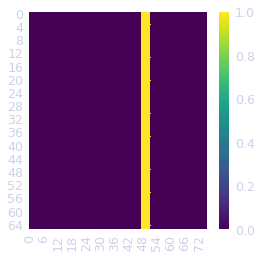

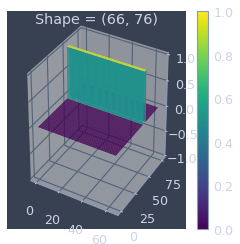

(<Figure size 288x288 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f0e8c63a0b8>)

In [9]:
res = 0.02
krock_body = 0.85 // res
surely_in_front_of_krock = int(krock_body + 10)
offset = patch_shape[1] - surely_in_front_of_krock
p = WallPatch(shape=patch_shape, strength=1, offset=offset, back=False)
p()
p.plot2d()
p.plot3d()

Let's define our pipeline to get an answer

In [10]:
from functools import partial

get_answer_from_model = Compose([get_learner, 
         lambda x: x[0].get_preds(), 
         get_probs_and_labels_from_preds])

get_answer = partial(get_answer_from_model,model_name,
                      model_dir, 
                      [])
answer = get_answer(dataset=PatchesDataset([p], get_transform(debug=True)))

In [11]:
answer

(tensor([[1., 0.]]), tensor([0]))

In [12]:
tensor2class = lambda x : {0: 'non traversable', 1 : 'traversable'}[x]

def answer2human(answer):
    probs = answer
    label = int(torch.argmax(probs).item())
    print('Model thinks it is "{}" with prob = {:.2f}%'.format(tensor2class(label), 
                                                                   probs[label] * 100))

In [13]:
def plot_probs(probs):
    fig = plt.figure()
    plt.title('Traversability probability over patches')
    plt.plot(probs[:,0], label='not traversable')
    plt.plot(probs[:,1], label='traversable')
    plt.legend()
    return fig

In [14]:
answer2human(answer[0][0])

Model thinks it is "non traversable" with prob = 100.00%


This makes sense, Krock cannot traverse a one meter tall wall in front of him. We can test the robustnees of our model by keeping the same height but changing the wall width. The results should always be the same

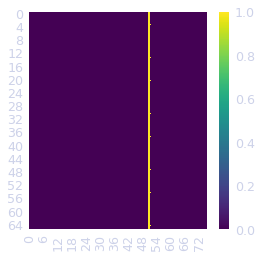

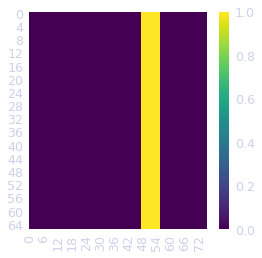

In [15]:
patches = [WallPatch(KrockPatchExtractStrategy.patch_shape(0.66), 
                     strength=1, 
                     back=False, 
                     offset=offset - int(s//2),
                     size=int(s))() for s in np.linspace(1, 8, 8)]
patches[0].plot2d()
patches[-1].plot2d()

In [16]:
get_answer(dataset=PatchesDataset(patches, get_transform()))

(tensor([[1.0000e+00, 3.8122e-12],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00],
         [1.0000e+00, 0.0000e+00]]), tensor([0, 0, 0, 0, 0, 0, 0, 0]))

Perfect all patches are non traversable

### Which wall can Krock  traverse?
What if we want to find out the maximum wall height krock can traverse. Let's create 100 walls where we increase the wall size by one cm at the time.

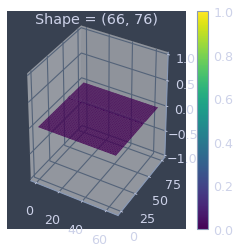

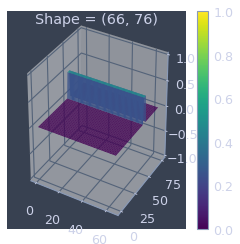

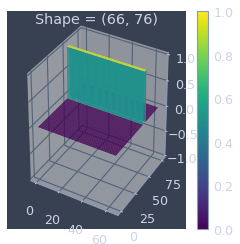

(<Figure size 288x288 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f0e8e8b5b38>)

In [17]:

patches = [WallPatch(KrockPatchExtractStrategy.patch_shape(0.66), strength=s, back=False, offset=offset)() for s in np.linspace(0.01, 1, 100)]

patches[0].plot3d()
patches[50].plot3d()
patches[-1].plot3d()

Let's get out answers.

In [18]:
probs, labels = get_answer(dataset=PatchesDataset(patches, get_transform()))
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

So more than 11cm won't make krock able to traverse a patch. We remember to the reader that krock is 13cm height in the gait configuration we used. Let's see how its prediction evolve with the increasing of the walls

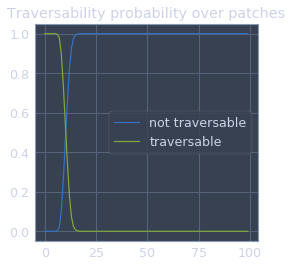

In [24]:
_ = plot_probs(probs)

In [26]:
answer2human(probs[10])

Model thinks it is "traversable" with prob = 54.21%


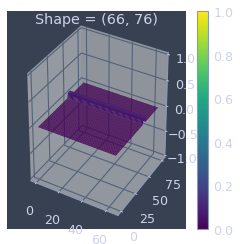

(<Figure size 288x288 with 2 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f0e8e7e1d68>)

In [27]:
patches[10].plot3d()

### Moving the wall to the right
Since we select a treshold smaller than the maximum advancement on the flat ground, moving the a wall that is not traversable in front of the robot to the edge should make a patch traversable since on the flat ground the robot is actually able to go faster.

In [28]:
patch_shape

(66, 76)

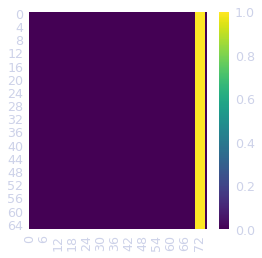

(66, 76)

In [33]:
p = WallPatch(patch_shape, offset=1, back=False)()
p.plot2d()
p.shape

In [34]:
answer2human(get_answer(dataset=PatchesDataset([p], get_transform()))[0][0])

Model thinks it is "traversable" with prob = 100.00%


Since our threshold is

In [35]:
print(TR)

0.2


We should espect the patch to become not traversable when the wall is at 20cm from the krock tail. So, we should place the wall extractly at 85cm + 20cm on the patch

24


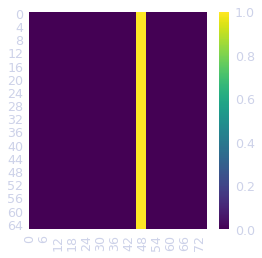

In [37]:
offset_in_tr = int( patch_shape[1] - (krock_body + (TR // res)))
wall_size = 4
print(offset_in_tr)
p = WallPatch(patch_shape, offset=offset_in_tr + wall_size//2, back=False, size=wall_size)()
p.plot2d()

In [40]:
answer2human(get_answer(dataset=PatchesDataset([p], get_transform()))[0][0])

Model thinks it is "non traversable" with prob = 100.00%


Correctly the model says that it is not traversable since the obstacle is included in our treshold.

Let's try to make a huge wall, 10 meters tall, on the right edge. The height should not influence the prediction

In [56]:
p = WallPatch(patch_shape, strength=1, offset=1, back=False)()
answer2human(get_answer(dataset=PatchesDataset([p], get_transform(scale=10)))[0][0])

Model thinks it is "traversable" with prob = 100.00%


Correctly, the model is not directly looking at how tall is the wall if we can correctly cover the advancement defined in the treshold.